## Overview

In this section, we will provide a demo of our system.

For ease of reference, the outline of the steps taken in this notebook is as follows:

1. Importing Required Libraries
2. Loading Training and Testing Datasets
3. Data Exploration
4. Data Preprocessing
5. Model Setup
6. Model Evaluation
7. Model Predictions

## Step 1: Importing Required Libraries

We begin by importing all required libraries.

In [1]:
# Built-in libraries
import json
import math
import os

# Numerical computing libraries
import numpy as np
import cv2
import pandas as pd
import seaborn as sns

# Visualisation and analysis
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# TensorFlow Keras API
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

We also set up the constants for this project.

In [2]:
BATCH_SIZE = 32
EPOCHS = 200
IMG_SIZE = 224
LABELS = ["female", "male"]

## Step 2: Loading Training and Testing Datasets

We now load the relevant training and testing datasets. In this *proof of concept* (POC), we shall use the following terminology:

- Training data: Data used for training models (this term may apply to either unperturbed or perturbed images)
- Validation data: Data used for testing and evaluating models

In [3]:
def get_data(data_dir, img_size=IMG_SIZE, labels=LABELS):
    """
    Load all image files.

    :param data_dir: path to data directory
    :param img_size: dimensions of each image
    :param labels: class labels for the dataset

    :return: an array of all images as matrices
    """
    data = []
    for class_num, label in enumerate(labels):
        path = os.path.join(data_dir, label)
        for img in os.listdir(path):
            try:
                # Convert images from BGR to RGB format
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1]
                # Reshaping the arrays to a form that can be processed
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=list)

In [4]:
# Load the datasets
# In this POC, perturbed data refers to facial data processed with makeup
preprocessing_fp = "preprocessing"
train = get_data(os.path.join(preprocessing_fp, "train_data"))
train_pert = get_data(os.path.join(preprocessing_fp, "makeup"))
val = get_data(os.path.join(preprocessing_fp, "val_data"))

## Step 3: Data Exploration

After we have loaded our datasets, we can analyse the composition of images in each of our datasets used in this POC.

In [5]:
def update_dataset_counter(counter, data, data_name):
    """
    Update a counter dictionary for a dataset.

    :param counter: dictionary acting as a counter
    :param data: dataset we are using
    :param data_name: name of the dataset
    """
    males = sum(1 for i in data if i[1])
    females = len(data) - males
    counter[f"female_{data_name}"] = females
    counter[f"male_{data_name}"] = males

In [6]:
# Initialise a counter
counter = dict()

# Update counter
for data_name in ("train", "train_pert", "val"):
    update_dataset_counter(counter, eval(data_name), data_name)

# Show number of images per dataset per gender
df = pd.DataFrame.from_dict(counter, orient="index")
df.index.name = "dataset"
df.reset_index(inplace=True)
df.columns.values[1] = "images"
df

,dataset,images
0,female_train,1250
1,male_train,1250
2,female_train_pert,1250
3,male_train_pert,1250
4,female_val,1250
5,male_val,1250


From the table above, it can be seen that all datasets used (`female_train`, `male_train`, `female_train_pert`, `male_train_pert`, `female_val`, `male_val`) are of equal sizes, which is 1250. This allows us to declare a constant for the dataset size.

In [7]:
DATASET_SIZE = 1250

## Step 4: Data Preprocessing

We can now preprocess the data for training the classifiers. In this POC, all values denoted as `x` are inputs and all values denoted as `y` are expected outputs (labels) for the corresponding `x` values.

In [8]:
def preprocess(dataset, img_size=IMG_SIZE):
    """
    Preprocess all images in a dataset.

    :param dataset: image dataset to preprocess
    :param img_size: size of images

    :return: a tuple of 2 arrays, containing the training data and their labels
        respectively
    """
    # Extract the features and labels of the dataset into individual lists
    x, y = zip(*dataset)
    
    # Rescale the images
    x = np.array(x) / 255
    
    # Resize all images
    x.reshape(-1, img_size, img_size, 1)
    
    # Convert y into an array
    y = np.array(y)
    
    return x, y

x_train, y_train = preprocess(train)
x_train_pert, y_train_pert = preprocess(train_pert)
x_val, y_val = preprocess(val)

The images are now in a suitable format for training the model.

:## Step 5: Model Setup

The model is built with Keras `Sequential` API. This will allow us to create models layer by layer, then connect them sequentially. The type of neural network that this model uses is a Convolutional Neural Network (CNN). A CNN consists of neurons with learnable weights and biases. Each artificial neuron accepts an input, performs matrix multiplication between the input data and the weights and outputs a non-linear transformation of the data.

The architecture of a CNN can be divided into the following components:

1. Input Layer
2. Convolutional Blocks
3. Fully-Connected Layer

### Input Layer

The input layer contains the raw pixel values of images represented in a *3D*-matrix. The dimensions are in the order of *W* $\times$ *H* $\times$ *D*, where *W* and *H* represent the width and height of the image respectively, and *D* represents the colour channels. In the case of this POC, we have images with a width of 224 pixels, a height of 224 pixels, and use 3 colour channels (Red, Green, Blue).

### Convolutional Blocks

This model will have three convolutional blocks that are made of:

1. **Convolutional Layers**
2. **ReLU (Rectified Linear Unit) Activation Layer**
3. **Max Pooling Layer**


**Convolutional** (CONV) **layers** make up the bulk of the convolutional blocks. CONV layers are the core building blocks of any CNN as they perform most computations. Using the Keras `Sequential` API, we can create and add CONV layers using Keras `Conv2D`. The important hyperparameters for CONV layers that will be mentioned are: the **number of filters** used, **stride**, **kernel size**, **padding** and the type of **activation function**.

1. The **number of filters** will affect the depth of the output. For example, to generate four different feature maps, we would need four distinct filters, thus creating a depth of four. For our model, the number of filters will vary from filter to filter. This can be accomplished by updating the `filters` parameter of our `Conv2D` function.

2. **Stride** refers to the number of rows and columns the kernel traverses per slide. Smaller strides generally lead to larger outputs, whereas larger strides lead to smaller outputs. For our model, we will be using the default setting of the `Conv2D` function, which is a stride of 1.

3. **Kernel size** can be represented as an integer or a tuple with two integers that specifies the *2D* convolution window. For our model, it will use a kernel size with a width and height of 3 pixels across all CONV layers. This is accomplished when we set the `kernel_size` parameter of our `Conv2D` function to `(3, 3)`.

4. There are several types of **padding**, including the `same` padding, `full` padding and `valid` padding. For our model, it will use the `same` padding. This is accomplished when we set the `padding` parameter of our `Conv2D` function to `same`. This will ensure that the output layer is the same size as the input layer.

5. Keras offers multiple types of layer `activation` functions. We will use the Rectified Linear Unit (ReLU) activation function for the `Conv2D` and `Dense` functions within the convolutional block. This is accomplished when we set the `activation` parameter of these functions to `relu`.

Additionally, we will employ dropout regularisation to prevent our model from overfitting. Overfitting is the event that a model fits the training data too well, affecting the model's ability to predict new and unseen data. Dropout regularisation is a technique that will randomly drop neurons when training the model. By doing so, the activation of neurons become sparse, thus causing the model to improve its ability to generalise.

The other two components of the convolutional blocks are the **ReLU activation layer** and **max pooling layer**. The ReLU activation layer uses a piecewise linear function that determines whether a node will output the given input (if positive) or output zero (otherwise). The max pooling layer, like the convolutional layer, filters across the input column and selects the pixel that has the greatest value to send to the output layer.

### Fully-Connected Layer

The purpose of the fully-connected (FC) layer is to perform class predictions. The input for this layer will be a flattened vector of nodes that have been activated in the earlier part of the model process. To flatten a vector of nodes, we will use the `Flatten` function at the beginning of the FC layer. This will turn *3D* feature maps into a *1D* input tensor. The FC layer will be constructed using `Dense` layers. As for the final output layer, it will use the `softmax` activation function which can be used for both binary and multi-class problems. This is accomplished by setting the `activation` parameter in the final `Dense` layer to `softmax`. Once the model is built, the model will then be compiled using the `Adam` optimizer with a learning rate of `0.000001`, a `SparseCategoricalCrossentropy` loss and `accuracy` as our performance metric.

In [9]:
def create_model():
    """
    Construct a neural network with the steps described above.
    
    :return: a CNN as described above
    """
    model = Sequential()

    # Input layer
    model.add(
        Conv2D(
            filters=32,
            kernel_size=(3, 3),
            padding="same",
            activation="relu",
            input_shape=(224, 224, 3),
        )
    )

    # Convolutional Layers
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(
        Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")
    )
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Fully-Connected Layer
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation="softmax"))

    opt = Adam(lr=0.000001)
    model.compile(
        optimizer=opt,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    return model

:Once we set up the model architecture, we can now train two models: one on unperturbed data and another on perturbed data.

In [10]:
# Construct the baseline (unperturbed) model
model = create_model()

# Save a checkpoint of the model for later use
checkpoint = ModelCheckpoint(
    "model_best_weights.h5",
    monitor="loss",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_freq="epoch",
)

# Train the model
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    verbose=0,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint],
)

# Store model history as a JSON file
with open(os.path.join("history", "model_history.json"), "w") as f:
    json.dump(history.history, f)# Construct the baseline (unperturbed) model
model = create_model()

# Save a checkpoint of the model for later use
checkpoint = ModelCheckpoint(
    "model_best_weights.h5",
    monitor="loss",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_freq="epoch",
)

# Train the model
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    verbose=0,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint],
)

# Store model history as a JSON file
with open(os.path.join("history", "model_history.json"), "w") as f:
    json.dump(history.history, f)

In [11]:
# Construct the perturbed model
model_pert = create_model()

# Save a checkpoint of the model for later use
checkpoint_pert = ModelCheckpoint(
    "model_best_weights_pert.h5",
    monitor="loss",
    verbose=0, 
    save_best_only=True,
    mode="min",
    save_freq="epoch",
)

# Train the model
history_pert = model_pert.fit(
    x_train_pert,
    y_train_pert,
    epochs=epochs,
    batch_size=batch_size,
    verbose=0,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint_pert],
)

# Store model history as a JSON file
with open(os.path.join("history", "model_pert_history.json"), "w") as f:
    json.dump(history_pert.history, f)

## Step 6: Model Evaluation

After the models have been trained, we can now evaluate the models using validation (testing) data.

We start by loading the training statistics of each model.

In [12]:
# Load history
keys = ("loss", "accuracy", "val_loss", "val_accuracy")

with open(os.path.join("history", "model_history.json")) as json_file:
    history = json.load(json_file)
    loss, acc, val_loss, val_acc = [history[key] for key in keys]

with open(os.path.join("history", "model_pert_history.json")) as json_pert_file:
    history_pert = json.load(json_pert_file)
    loss_pert, acc_pert, val_loss_pert, val_acc_pert = [history_pert[key] for key in keys]

### Accuracy and Loss

We can now visualise the accuracy and loss during the training stage for both models.

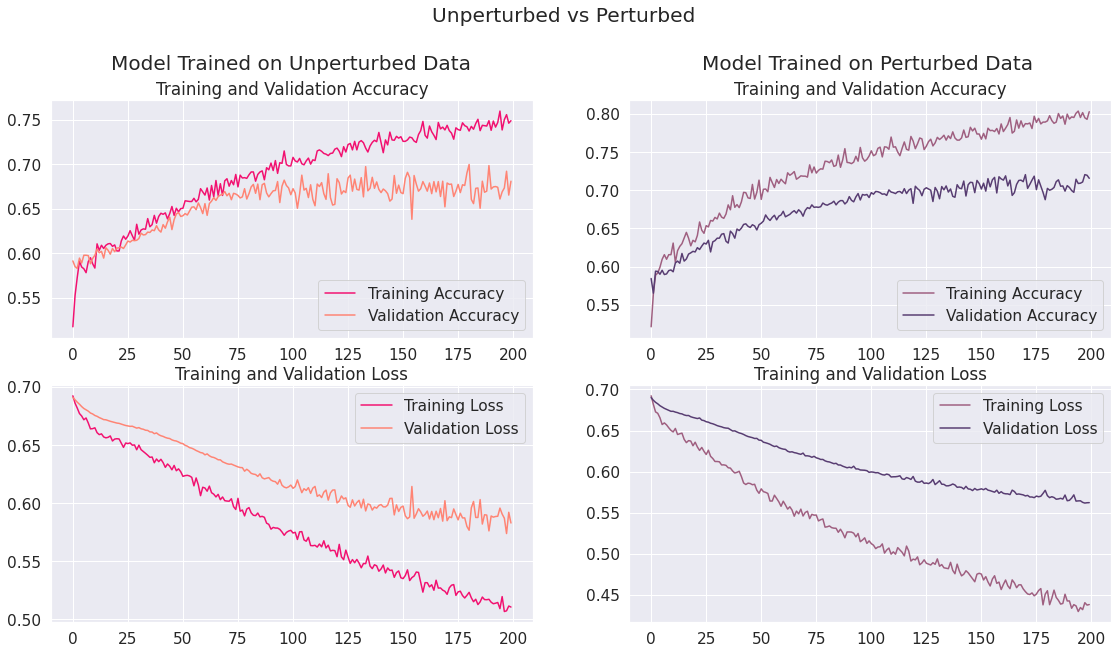

In [34]:
# Set up figure
epochs_range = range(EPOCHS)

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(19, 10))
fig.suptitle("Unperturbed vs Perturbed")
fig.subplots_adjust(top=0.85)

# Unperturbed model
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy", c="#f21170")
plt.plot(epochs_range, val_acc, label="Validation Accuracy", c="#ff8474")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(2, 2, 3)
plt.plot(epochs_range, loss, label="Training Loss", c="#f21170")
plt.plot(epochs_range, val_loss, label="Validation Loss", c="#ff8474")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

# Perturbed model
plt.subplot(2, 2, 2)
plt.plot(epochs_range, acc_pert, label="Training Accuracy", c="#9f5f80")
plt.plot(epochs_range, val_acc_pert, label="Validation Accuracy", c="#583d72")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(2, 2, 4)
plt.plot(epochs_range, loss_pert, label="Training Loss", c="#9f5f80")
plt.plot(epochs_range, val_loss_pert, label="Validation Loss", c="#583d72")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

# Tweak graphs and add text
ext = [
    [72.0 * 2.5, 97.04347826086959 * 2.25],
    [188.4521739130435 * 2.25, 97.04347826086956 * 2.25],
    [304.904347826087 * 2.4, 97.04347826086956 * 2.4],
    [421.35652173913047 * 2.4, 97.04347826086962 * 2.4],
]
inv = fig.transFigure.inverted()
width_left = ext[0][0] + (ext[1][0] + ext[1][1] - ext[0][0]) / 2.0
left_center = inv.transform((width_left, 1))
width_right = ext[2][0] + (ext[3][0] + ext[3][1] - ext[2][0]) / 2.0
right_center = inv.transform((width_right, 1))
plt.figtext(
    left_center[0],
    0.9,
    "Model Trained on Unperturbed Data",
    va="center",
    ha="center",
    size=20,
)
plt.figtext(
    right_center[0],
    0.9,
    "Model Trained on Perturbed Data",
    va="center",
    ha="center",
    size=20,
)

sns.set_style("darkgrid")

# Show graphs
plt.show()

The figure above shows a comparison of our two models, one trained on unperturbed data, and the other trained on perturbed data. The comparison involves evaluating the training and validation accuracy, and the training and validation loss between the two models. First, we will compare the training and validation accuracy between the two models. Comparing the trend of both lines (training accuracy and validation accuracy) from the two models, we can see that they are very similar. As the model reaches the maximum number of epochs, the training and validation accuracy of the model tends to increase. Likewise, as the model reaches the maximum number of epochs, the training and validation loss of the model tends to decrease.

#### Validation Accuracy and Loss

In this section, we discuss the accuracies and losses of the two models. First, the validation accuracy of the model trained on unperturbed data is ~70%. On the other hand, the model trained on perturbed data reaches a slightly greater validation accuracy with ~72%. In other words, we should expect that the model trained on unperturbed data and perturbed data will achieve ~70% and ~72% accuracy respectively on new data. This information is mirrored if we were to compare the validation loss of the two models. Although the two models begin with similar validation losses of ~0.69, at Epoch 200 the model trained on unperturbed data reaches a validation loss of ~0.58 whereas the other model trained on perturbed data reaches a validation loss of ~0.56. In general, the evaluation suggests that to achieve greater validation accuracy and loss, we should apply some perturbations to the input images before passing them to the model.

#### Overfitting

We can check the validation metrics (accuracy and loss) of the model to identify whether the model is overfitting. Since validation accuracy and loss can both be used to identify whether a model is overfitting in similar ways, we will only consider validation accuracy for our analysis.

Looking at the validation accuracy for the model trained on unperturbed data (as pointed out earlier), at the start of the graph, the validation accuracy increases as the epoch increases. However, at around Epoch 75, the validation accuracy seems to no longer have an upwards trend. On the other hand, training accuracy continues to increase steadily even after Epoch 200. This would suggest that the model trained on unperturbed data begins to overfit after Epoch 75.

The validation accuracy of the model trained on perturbed data follows a similar trend. At the beginning of the graph, the validation accuracy has a growing trend but stops after Epoch 100, where it now shows signs of overfitting. Moreover, the training accuracy of this model continues to increase even after Epoch 200, just like the model trained on unperturbed data.

### Confusion Matrix

To continue our evaluation of the model, we will be looking at the **confusion matrix** produced by the `confusion_matrix` function provided by `scikit-learn`. This matrix will enable us to discuss the performance of our binary classification model using test data where the true values are given. Before moving on, there are some terms which we will define in the context of our project:

- **True Positive (TP):** The actual class was male, and the model correctly predicted male
- **True Negative (TN):** The actual class was female, and the model correctly predicted female
- **False Positive (FP):** The actual class was female, but the model incorrectly predicted male
- **False Negative (FN):** The actual class was male, but the model incorrectly predicted female 

We will be analysing the accuracy, precision, and recall of our model.

The following code is used to generate our confusion matrices.

In [14]:
test_datagen = ImageDataGenerator(rescale=1/255)
val_gen = test_datagen.flow_from_directory(
    os.path.join(preprocessing_fp, "val_data"),
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)

# Generate confusion matrix for unperturbed data
Y_pred = model.predict(val_gen, DATASET_SIZE * 2 // BATCH_SIZE)
y_pred = np.argmax(Y_pred, axis=1)
cf_matrix = confusion_matrix(val_gen.classes, y_pred)

# Generate confusion matrix for perturbed data
Y_pred_pert = model_pert.predict(val_gen, DATASET_SIZE * 2 // BATCH_SIZE)
y_pred_pert = np.argmax(Y_pred_pert, axis=1)
cf_matrix_pert = confusion_matrix(val_gen.classes, y_pred_pert)

Found 2500 images belonging to 2 classes.


We can plot the confusion matrices of our two models with the following code.

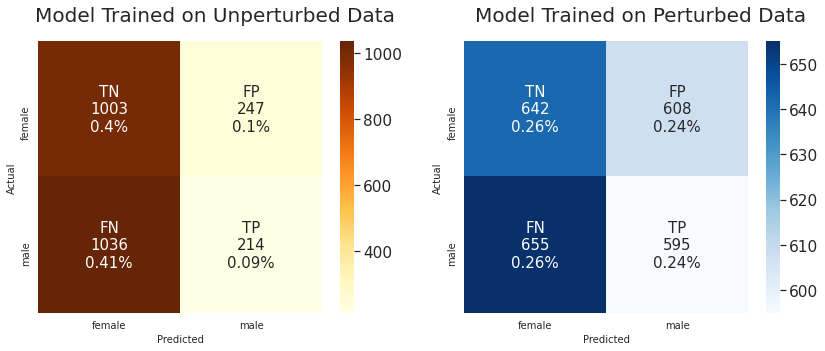

In [15]:
f, ax = plt.subplots(1, 2, sharex=True, figsize=(14, 5))

# Unperturbed data
group_names = ["TN", "FP", "FN", "TP"]
group_counts = map(round, cf_matrix.flatten())
group_percentages = (
    f"{round(value, 2)}%" for value in cf_matrix.flatten() / np.sum(cf_matrix)
)
df_cm = pd.DataFrame(cf_matrix, range(2), range(2))
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
labels = np.asarray(
    ["\n".join(map(str, v)) for v in zip(group_names, group_counts, group_percentages)]
).reshape(2, 2)

# Perturbed data
group_counts_pert = map(round, cf_matrix_pert.flatten())
group_percentages_pert = (
    f"{round(value, 2)}%" for value in cf_matrix_pert.flatten() / np.sum(cf_matrix_pert)
)
df_cm_pert = pd.DataFrame(cf_matrix_pert, range(2), range(2))
df_cm_pert.index.name = "Actual"
df_cm_pert.columns.name = "Predicted"
labels_pert = np.asarray(
    [
        "\n".join(map(str, v))
        for v in zip(group_names, group_counts_pert, group_percentages_pert)
    ]
).reshape(2, 2)

# Confusion matrix titles
width_left = ext[0][0] + (ext[1][0] + ext[1][1] - ext[0][0]) / 2
left_center = inv.transform((width_left, 1))
width_right = ext[2][0] + (ext[3][0] + ext[3][1] - ext[2][0]) / 2
right_center = inv.transform((width_right, 1))
plt.figtext(
    left_center[0],
    0.95,
    "Model Trained on Unperturbed Data",
    va="center",
    ha="center",
    size=20,
)
plt.figtext(
    right_center[0],
    0.95,
    "Model Trained on Perturbed Data",
    va="center",
    ha="center",
    size=20,
)

sns.set(font_scale=1.4)  # for label size
sns.heatmap(
    df_cm,
    annot=labels,
    annot_kws={"size": 15},
    cmap="YlOrBr",
    fmt="",
    ax=ax[0],
    xticklabels=LABELS,
    yticklabels=LABELS,
)
sns.heatmap(
    df_cm_pert,
    annot=labels_pert,
    annot_kws={"size": 15},
    cmap="Blues",
    fmt="",
    ax=ax[1],
    xticklabels=LABELS,
    yticklabels=LABELS,
)
sns.set_style("darkgrid")
plt.show()

We can also generate a classification report.

In [16]:
print("---------------------------------------------------------")
print("Model trained on Unperturbed Data")
print("---------------------------------------------------------")
print(
    classification_report(
        val_gen.classes, y_pred, target_names=LABELS, zero_division=1
    )
)
print("---------------------------------------------------------")
print("Model trained on Perturbed Data")
print("---------------------------------------------------------")
print(
    classification_report(
        val_gen.classes, y_pred_pert, target_names=LABELS, zero_division=1
    )
)

---------------------------------------------------------
Model trained on Unperturbed Data
---------------------------------------------------------
              precision    recall  f1-score   support

      female       0.49      0.80      0.61      1250
        male       0.46      0.17      0.25      1250

    accuracy                           0.49      2500
   macro avg       0.48      0.49      0.43      2500
weighted avg       0.48      0.49      0.43      2500

---------------------------------------------------------
Model trained on Perturbed Data
---------------------------------------------------------
              precision    recall  f1-score   support

      female       0.49      0.51      0.50      1250
        male       0.49      0.48      0.49      1250

    accuracy                           0.49      2500
   macro avg       0.49      0.49      0.49      2500
weighted avg       0.49      0.49      0.49      2500



For our evaluation of accuracy, precision, and recall, we will reference the `classification_report` and `confusion_matrix` of our two distinct models generated above.

Let $f$ and $m$ be subsets of the validation data labelled `female` and `male` respectively.

#### Accuracy

Accuracy is the ratio of the number of correctly labelled images over the total number of samples, given by the formula:

$$
\frac{TP + TN}{TP + TN + FP + FN}
$$

Since the analysis of accuracies of the two models were completed in an earlier section of this POC, we will continue to analyse other metrics.

#### Precision

In this project, the precision of classifying **females** (negative predictive value) is given by the formula:

$$
\frac{TN_f}{TN_f + FN_f}
$$

Likewise, the precision of classifying **males** (positive predictive value) is given by the formula:

$$
\frac{TP_m}{TP_m + FP_m}
$$

where $TN_f$, $FN_f$, $TN_m$, $FN_m$ represent the true negative over $f$, false negative over $f$, true negative over $m$, false negative over $m$ respectively.

Looking at the precision metrics of the two models, we can see that the precision value for male and female subjects are very similar across the two models (~0.50). These values suggest that when an image is classified, we can only be 50% sure that the classification is true.

#### Recall

In this project, the recall for classifying **females** (true negative rate) is given by the formula:

$$
\frac{TN_f}{TN_f + FP_m}
$$

Recall for classifying **males** (true positive rate) is given by the formula:
$$
\frac{TP_m}{TP_m + FN_f}
$$

where $TN_f$, $FP_m$, $TP_m$, $FN_f$ represent the true negative over $f$, false positive over $m$, true positive over $m$, false negative over $f$ respectively.

Looking at the recall metrics of the two models, we can see that the model trained on unperturbed data has a much higher recall for females than males. In other words, the rate of true negatives is much greater than the rate of true positives. This suggests that the model trained on unperturbed data is much better in classifying females than males. As for the model trained on perturbed data, the recall is much more balanced with ~0.02 difference. This suggests that this model is as good at classifying females as with males.

### Gender Bias Index

For the final part of our model evaluation, we will compare the gender bias index between the two models. First, we will look at the gender bias index of the model trained on unperturbed data.

In [17]:
def gen_acc(matrix, female_size=DATASET_SIZE, male_size=DATASET_SIZE, verbose=False):
    """
    Compute the accuracy of a model.

    :param matrix: confusion matrix of the model
    :param female_size: number of images labelled female
    :param male_size: number of images labelled male
    :param verbose: if True, this will output the overall results

    :return: a tuple of the respective accuracy for females, males, and the overall
        model accuracy
    """
    true_neg = matrix[0][0]
    true_pos = matrix[1][1]
    female_acc = true_neg / female_size
    male_acc = true_pos / male_size
    global_acc = (true_neg + true_pos) / (female_size + male_size)
    if verbose:
        print(f"Overall Categorical Accuracy: {round(global_acc * 100, 2)}%")
    return female_acc, male_acc, global_acc


def gen_gbi(matrix):
    """
    Compute the gender bias index of a model.

    :param matrix: confusion matrix of the model

    :return: a string indicating the gender bias index of a model
    """
    female_acc, male_acc, global_acc = gen_acc(matrix)
    gender_bias_index = female_acc - male_acc
    return f"Gender Bias Index: {round(gender_bias_index, 2)}"

We start by evaluating the gender bias index of the baseline model (trained on the unperturbed dataset).

In [18]:
gen_gbi(cf_matrix)

'Gender Bias Index: 0.63'

The gender bias index of the model trained on unperturbed data was found to be 0.63. This value suggests that this model is biased towards females.

Now, we shall generate the gender bias index of the model trained on perturbed data.

In [19]:
gen_gbi(cf_matrix_pert)

'Gender Bias Index: 0.04'

As we can see, the gender bias index of the model trained on perturbed data is 0.04, a much lower value compared to the gender bias index of the model trained on unperturbed data. This suggests that this model has a slight bias towards females but is much fairer in its attempt to classify gender than the model trained on unperturbed data.

### Discussion

This section for model evaluation has looked at the accuracies and losses, confusion matrices, and gender bias indices of the two models. When we compared the accuracies and losses of the two models, we analysed the trend, the highest validation accuracy and minimum validation loss of the two models. More importantly, we were also able to identify the point (epoch) when the models began to overfit. For the model trained on unperturbed data, the model began to overfit at Epoch 75. As for the model trained on perturbed data, the model began to overfit at Epoch 100, but the training validation of the two models remained on an uptrend even after Epoch 200.

In the section where we evaluate the confusion matrices of the two models, we looked at important metrics: accuracy, precision, and recall. When we analysed the precision of the two models, it was found that they both had very similar values and that we can only be ~50% sure that any classification is true. More interestingly, it was found that the model trained on unperturbed data has a much higher recall for females than males. This suggests that this model is better at classifying females compared to males. On the other hand, the model trained on perturbed data was found to have more balanced recall values across the two genders.

Finally, we compared the gender bias indices of the two models. The gender bias index reflects the results from the confusion matrices, as shown where the model trained on unperturbed data is more biased towards one gender (female) than the model trained on perturbed data. The gender bias indices of the model trained on unperturbed data and the model trained on perturbed data were found to be 0.63 and 0.04 respectively.

From our model evaluation, the finding that the model trained on perturbed data was less affected by gender bias was not within our initial expectations as we assumed this model would have a bias towards females. Therefore, our team would need to investigate this issue further as these findings remain inconclusive.

### Step 7: Model Predictions

In this section, we will present some individual predictions made by each model.

First, we will randomly select 9 images for testing.

In [20]:
class_subset = sorted(os.listdir(os.path.join(preprocessing_fp, "val_data")))[:10]
test_generator = ImageDataGenerator(rescale=1/255)
testgen = test_generator.flow_from_directory(
    os.path.join(preprocessing_fp, "val_data"),
    target_size=(128, 128),
    batch_size=1,
    class_mode=None,
    classes=class_subset, 
    shuffle=False,
)

# Generate 9 test samples
samples = np.random.choice(testgen.samples, size=9, replace=False)

Found 2500 images belonging to 2 classes.


Next, we can plot the predictions made by the model trained on unperturbed data.

In [21]:
def plot_predictions(y_true, y_preds, test_generator, samples, labels=LABELS):
    """
    Plot the predictions for a model.
    
    :param y_true: actual labels for the dataset
    :param y_preds: predictions made by the model
    :param test_generator: generator object that generated the images
    :param samples: image samples to test
    :param labels: class labels for the dataset
    """
    fig = plt.figure(figsize=(10, 7))
    for i, idx in enumerate(samples):
        ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))

        some_pred = max(range(2), key=y_preds[idx].__getitem__)
        some_true = y_true[idx]
        plt.tight_layout()
        ax.set_title(
            f"Predicted: {labels[some_pred]}\nActual: {labels[some_true]}",
            color="green" if some_pred == some_true else "red",
        )

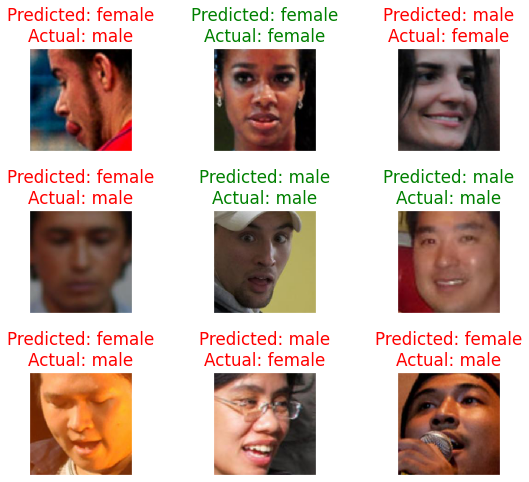

In [22]:
predicted_classes = model.predict(val_gen)
plot_predictions(val_gen.classes, predicted_classes, testgen, samples)

As reported previously, the baseline model shows a bias to make `female` predictions, with 8 out of 9 predictions being female. Although this means that 4 out of 4 females were correctly classified, only 1 out of 5 males was correctly classified.

Now, we will generate another 9 predictions using the model trained on perturbed data.

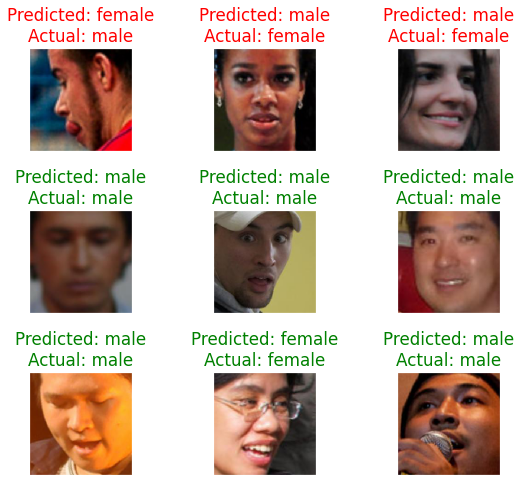

In [23]:
predicted_classes_pert = model_pert.predict(val_gen)
plot_predictions(val_gen.classes, predicted_classes_pert, testgen, samples)

Unlike the baseline model, the model trained on perturbed data does not give a `female` prediction for almost every image, showing less gender bias. 5 out of 9 predictions were female and 4 out of 9 predictions were male. 2 out of 4 females were correctly classified and 2 out of 5 males were correctly classified.